In [215]:
import pickle
import os, sys
from astropy import units as u, constants as c
import numpy as np
from matplotlib import pyplot as plt
import emcee, tqdm
from scipy.special import erf

In [216]:
with open("simstack.pkl", "rb") as f:
    results = pickle.load(f)
rkeys = list(results.keys())
bkeys = list(results['seds'].keys())
rkeys, results['wvs'], len(bkeys), bkeys[0]

(['wvs',
  'seds',
  'stds',
  'ngals',
  'z_med',
  'boot',
  'cov',
  'm_med',
  'nd',
  'beams'],
 [24.0, 100.0, 160.0, 250.0, 350.0, 500.0, 850.0],
 96,
 'z=0.01_0.5__logM=9.5_10.0__SF?=0')

In [217]:
if "nd" not in rkeys:
    results['nd'] = {}
    for bkey in bkeys:
        y = results['seds'][bkey]
        yerr_diag = np.diag(results['cov'][bkey])
        results['nd'][bkey] = (y - np.sqrt(yerr_diag)) < 0 
        # wavs for which the data is below the 1-sigma error
    with open("simstack.pkl", "wb") as f:
        pickle.dump(results, f)
        
if "beams" not in rkeys:
    results['beams'] = np.array([1.55, 2.03, 4.66, 9.94, 17.65, 37.30, 5.68]) * 1e-9
    # values from the Viero+22 paper 2203.14312, Viero+13 paper 1304.0446, and 
    # SCUBA beam from https://academic.oup.com/mnras/article/465/2/1789/2454739
    with open("simstack.pkl", "wb") as f:
        pickle.dump(results, f)

In [218]:
def black(nu_in, T):
    # h = 6.623e-34     ; Joule*s
    # k = 1.38e-23      ; Joule/K
    # c = 3e8           ; m/s
    # (2*h*nu_in^3/c^2)*(1/( exp(h*nu_in/k*T) - 1 )) * 10^29

    a0 = 1.4718e-21  # 2*h*10^29/c^2
    a1 = 4.7993e-11  # h/k

    num = a0 * nu_in ** 3.0
    den = np.exp(a1 * np.outer(1.0 / T, nu_in)) - 1.0
    ret = num / den

    return ret

def graybody_fn(theta, x, alphain=2.0, betain=1.8):
    A, T = theta

    c_light = 299792458.0  # m/s

    nu_in = np.array([c_light * 1.e6 / wv for wv in x])
    ng = np.size(A)

    base = 2.0 * (6.626) ** (-2.0 - betain - alphain) * (1.38) ** (3. + betain + alphain) / (2.99792458) ** 2.0
    expo = 34.0 * (2.0 + betain + alphain) - 23.0 * (3.0 + betain + alphain) - 16.0 + 26.0
    K = base * 10.0 ** expo
    w_num = 10 ** A * K * (T * (3.0 + betain + alphain)) ** (3.0 + betain + alphain)
    w_den = (np.exp(3.0 + betain + alphain) - 1.0)
    w_div = w_num / w_den
    nu_cut = (3.0 + betain + alphain) * 0.208367e11 * T
    graybody = np.reshape(10 ** A, (ng, 1)) * nu_in ** np.reshape(betain, (ng, 1)) * black(nu_in, T) / 1000.0
    powerlaw = np.reshape(w_div, (ng, 1)) * nu_in ** np.reshape(-1.0 * alphain, (ng, 1))
    graybody[np.where(nu_in >= np.reshape(nu_cut, (ng, 1)))] = \
        powerlaw[np.where(nu_in >= np.reshape(nu_cut, (ng, 1)))]

    return graybody

graybody_fn((35, 30), results['wvs'])[0]

array([7.849749348802555e+67, 9.491263797299263e+68,
       6.269838296032081e+68, 2.4115712517811536e+68,
       9.489396082112747e+67, 3.1247471874483694e+67,
       5.195790115816918e+66], dtype=object)

z=0.01_0.5__logM=9.5_10.0__SF?=1


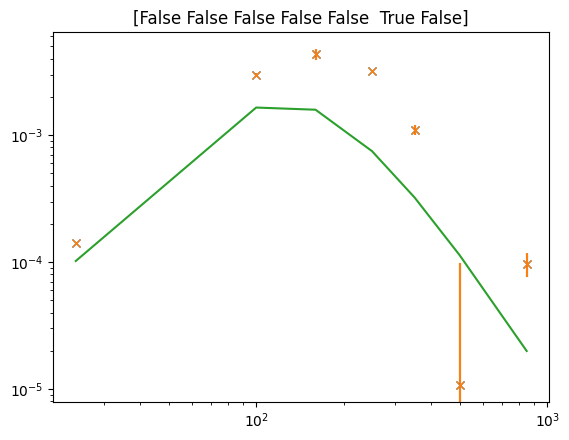

In [219]:
key_to_plot = bkeys[1]
print(key_to_plot)
plt.figure()
plt.title(results['nd'][key_to_plot])
plt.errorbar(results['wvs'], results['seds'][key_to_plot], yerr=results['stds'][key_to_plot], fmt='x')
plt.errorbar(results['wvs'], results['seds'][key_to_plot], yerr=np.sqrt(np.diag(results['cov'][key_to_plot])), fmt='x')
plt.plot(results['wvs'], graybody_fn((-36.3, 24.6), results['wvs'])[0])
plt.loglog()
plt.show()
plt.close()

emcee time

In [225]:
def log_prior(theta, Amin=-38, Amax=-33, Tmin=5, Tmax=32):
    A, T = theta
    if Amin < A < Amax and Tmin < T < Tmax:
        return 0.0
    return -np.inf

def log_prior_informative(theta, theta0, Amin=-38, Amax=-33, Tmin=5, Tmax=32, error_infl=1.0):
    A, T = theta
    A0, T0, sigma_T = theta0
    if Amin < A < Amax and Tmin < T < Tmax and sigma_T is not None:
        lp = -0.5 * (np.sum((T - T0) ** 2 / (sigma_T * error_infl) ** 2)) + \
                np.log(1.0 / (np.sqrt(2 * np.pi) * (sigma_T * error_infl) ** 2))
        return lp
    return -np.inf

def log_likelihood(theta, x, y, yerr, nd, sig_upp_lim=3.0):
    x_d, y_d, x_nd, y_nd = x[~nd], y[~nd], x[nd], y[nd] # 1d arrays
    for i in np.where(nd)[::-1]:
        yerr_d = np.delete(yerr, i, axis=0)
        yerr_d = np.delete(yerr_d, i, axis=1)
    nd_ulim = np.diag(yerr)[nd] # upper limit
    
    model_d = graybody_fn(theta, x_d)[0]
    dy = y_d - model_d
    ll_d = -.5 * (np.matmul(dy, np.matmul(np.linalg.inv(yerr_d), dy)) \
        + len(dy) * np.log(2 * np.pi) + np.log(np.linalg.det(yerr_d)))
    
    model_nd = graybody_fn(theta, x_nd)[0]
    ll_nd = np.sum(np.log(np.sqrt(np.pi / 2 * np.sqrt(nd_ulim)) * (
        erf((np.sqrt(nd_ulim) * sig_upp_lim - model_nd) / np.sqrt(2 * nd_ulim)) + 
        erf(model_nd / np.sqrt(2 * nd_ulim)))))
    
    if not np.isfinite(ll_d) or not np.isfinite(ll_nd):
        return -np.inf
    
    return ll_d + ll_nd

def log_probability(theta, x, y, yerr, nd, theta0=None):
    # if theta0 is provided, use informative prior
    lp = log_prior(theta) if theta0 is None else log_prior_informative(theta, theta0)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr, nd)

In [172]:
key_to_fit = bkeys[1]

x = np.array(results['wvs'])
y = np.array(results['seds'][key_to_fit])
yerr = np.array(results['cov'][key_to_fit])
nd = np.array(results['nd'][key_to_fit])

theta0 = (-36.3, 24.6)
ndim, nwalkers = len(theta0), 32
initial = theta0 + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr, nd))

In [173]:
nsteps = 5000
sampler.run_mcmc(initial, nsteps, progress=True)

  1%|          | 40/5000 [00:00<00:12, 391.62it/s]/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_50232/2942199177.py:20: RuntimeWarning: divide by zero encountered in log
  ll_nd = np.sum(np.log(np.sqrt(np.pi / 2 * np.sqrt(nd_ulim)) * (
100%|██████████| 5000/5000 [00:12<00:00, 388.82it/s]


State([[-35.22958115  17.86441559]
 [-35.23814561  17.96277151]
 [-35.19756257  17.71442147]
 [-35.23810245  17.98924699]
 [-35.20235667  17.64897712]
 [-35.24587953  18.03583909]
 [-35.21987582  17.8077686 ]
 [-35.21567493  17.7764465 ]
 [-35.21582732  17.8095749 ]
 [-35.24187675  17.95156062]
 [-35.20953371  17.79357999]
 [-35.20963278  17.6964968 ]
 [-35.27059799  18.0709556 ]
 [-35.24891646  17.9776713 ]
 [-35.21442969  17.79077671]
 [-35.21765361  17.80995308]
 [-35.20556631  17.70475853]
 [-35.22489384  17.77496418]
 [-35.22475924  17.75708103]
 [-35.21902297  17.84668437]
 [-35.26035826  17.99303677]
 [-35.19826084  17.67863128]
 [-35.22876377  17.78888098]
 [-35.19065596  17.68827521]
 [-35.19302597  17.63654518]
 [-35.2353928   17.88946333]
 [-35.22518289  17.8421123 ]
 [-35.21554652  17.76445152]
 [-35.23105404  17.99585595]
 [-35.23647818  17.92867526]
 [-35.2247073   17.75369787]
 [-35.23058048  17.88603417]], log_prob=[-49.53744694 -50.5669452  -50.41859419 -51.07412589 -5

-35.21921657568363 17.798020161985416


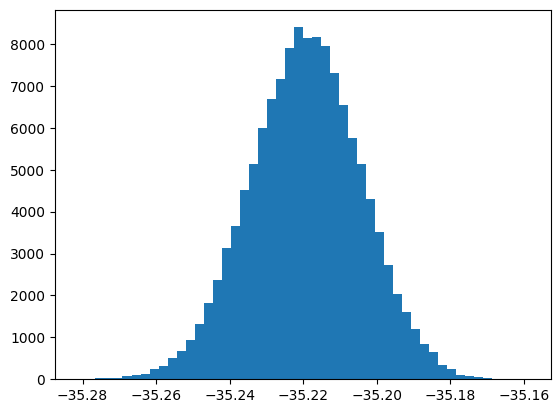

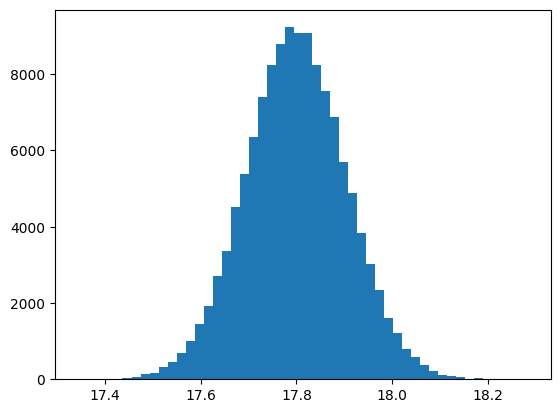

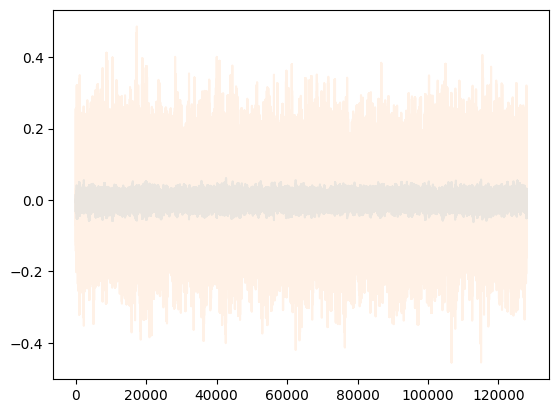

In [174]:
samples = sampler.get_chain(discard=1000, flat=True)
As, Ts = samples[:, 0], samples[:, 1]
Abest, Tbest = np.median(As), np.median(Ts)
print(Abest, Tbest)

plt.figure()
plt.hist(As, bins=50)
plt.show()
plt.close()

plt.figure()
plt.hist(Ts, bins=50)
plt.show()
plt.close()

plt.figure()
plt.plot(samples - np.median(samples, axis=0), alpha=0.1)
plt.show()
plt.close()


In [175]:
wvs = results['wvs']
C_best = graybody_fn((Abest, Tbest), wvs)[0]

C_samples = np.array([graybody_fn((A, T), wvs)[0] for A, T in samples])
C_std = np.std(C_samples, axis=0)

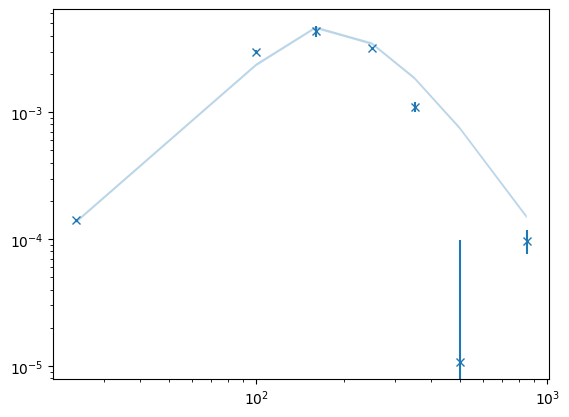

In [176]:
plt.figure()
plt.errorbar(wvs, y, yerr=np.sqrt(np.diag(yerr)), fmt='x')
# plt.plot(wvs, C_best)
plt.fill_between(wvs, C_best - C_std, C_best + C_std, alpha=0.3)
plt.loglog()
plt.show()
plt.close()

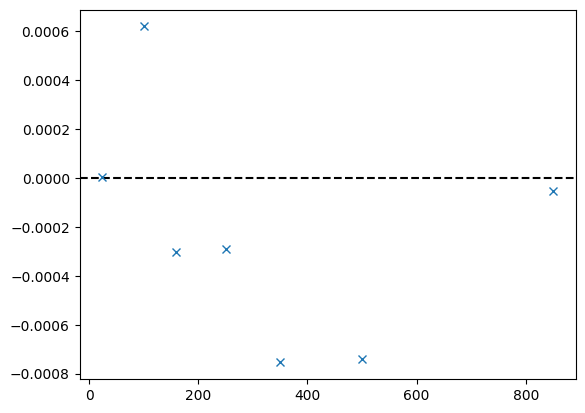

In [177]:
# plot residuals 
plt.figure()
plt.errorbar(wvs, y - C_best, fmt='x')
plt.axhline(0, color='k', ls='--')
plt.show()
plt.close()

In [178]:
CII_wav = 157.74 # microns
zs = np.array(wvs) / CII_wav - 1
wvs, zs

([24.0, 100.0, 160.0, 250.0, 350.0, 500.0, 850.0],
 array([-0.84785089, -0.36604539,  0.01432737,  0.58488652,  1.21884113,
         2.16977304,  4.38861418]))

In [179]:
results['z_med']

{'z=0.01_0.5__logM=9.5_10.0__SF?=0': 0.3985,
 'z=0.01_0.5__logM=9.5_10.0__SF?=1': 0.3594,
 'z=0.01_0.5__logM=10.0_10.5__SF?=0': 0.4252,
 'z=0.01_0.5__logM=10.0_10.5__SF?=1': 0.37275,
 'z=0.01_0.5__logM=10.5_11.0__SF?=0': 0.4259,
 'z=0.01_0.5__logM=10.5_11.0__SF?=1': 0.40315,
 'z=0.01_0.5__logM=11.0_12.0__SF?=0': 0.42955,
 'z=0.01_0.5__logM=11.0_12.0__SF?=1': 0.4127,
 'z=0.5_1.0__logM=9.5_10.0__SF?=0': 0.8117,
 'z=0.5_1.0__logM=9.5_10.0__SF?=1': 0.83385,
 'z=0.5_1.0__logM=10.0_10.5__SF?=0': 0.82775,
 'z=0.5_1.0__logM=10.0_10.5__SF?=1': 0.832,
 'z=0.5_1.0__logM=10.5_11.0__SF?=0': 0.82825,
 'z=0.5_1.0__logM=10.5_11.0__SF?=1': 0.8343,
 'z=0.5_1.0__logM=11.0_12.0__SF?=0': 0.7898499999999999,
 'z=0.5_1.0__logM=11.0_12.0__SF?=1': 0.84625,
 'z=1.0_1.5__logM=9.5_10.0__SF?=0': 1.1417,
 'z=1.0_1.5__logM=9.5_10.0__SF?=1': 1.2725,
 'z=1.0_1.5__logM=10.0_10.5__SF?=0': 1.1758,
 'z=1.0_1.5__logM=10.0_10.5__SF?=1': 1.2674500000000002,
 'z=1.0_1.5__logM=10.5_11.0__SF?=0': 1.1922,
 'z=1.0_1.5__logM=10.5_

Let's look at the "z=1.0_1.5" bin with z = 1.21884113 possibility in the 350 $\mu\text{m}$ map

In [244]:
special_wv_index = 3
map_wv = results['wvs'][special_wv_index]
map_z = zs[special_wv_index]
zbin_used = "z=0.5_1.0"

print(map_wv, map_z, zbin_used)

z_ran = zbin_used.split("_")[0].split("=")[1], zbin_used.split("_")[1]
assert(float(z_ran[0]) <= map_z < float(z_ran[1]))

250.0 0.5848865221250157 z=0.5_1.0


In [245]:
# Viero+22 uses their informative prior in these bins
informative_prior = ['z=1.5_2.0__logM=9.5_10.0__SF?=1',
                    'z=2.0_2.5__logM=9.5_10.0__SF?=1',
                    'z=2.0_2.5__logM=10.0_10.5__SF?=1',
                    'z=3.0_3.5__logM=9.5_10.0__SF?=1',
                    'z=3.5_4.0__logM=10.0_10.5__SF?=1',
                    'z=5.0_6.0__logM=9.5_10.0__SF?=1',
                    'z=6.0_8.0__logM=10.5_11.0__SF?=1',
                    'z=6.0_8.0__logM=11.0_12.0__SF?=1']

z=0.5_1.0__logM=9.5_10.0__SF?=1 9164 0.83385
use informative prior: False
theta0: -36.3609565 15.058184872808571 27.614452329 None


  0%|          | 0/1500 [00:00<?, ?it/s]/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_50232/2613829419.py:29: RuntimeWarning: divide by zero encountered in log
  ll_nd = np.sum(np.log(np.sqrt(np.pi / 2 * np.sqrt(nd_ulim)) * (
100%|██████████| 1500/1500 [00:07<00:00, 196.05it/s]


best: -35.703638345137385 17.686874619093732 32.43507502022504


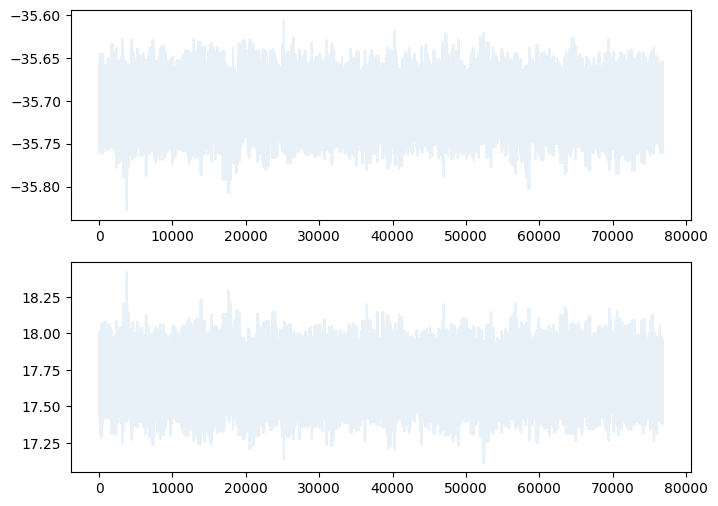

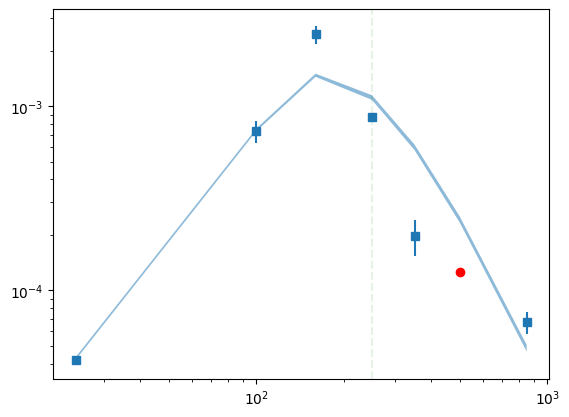

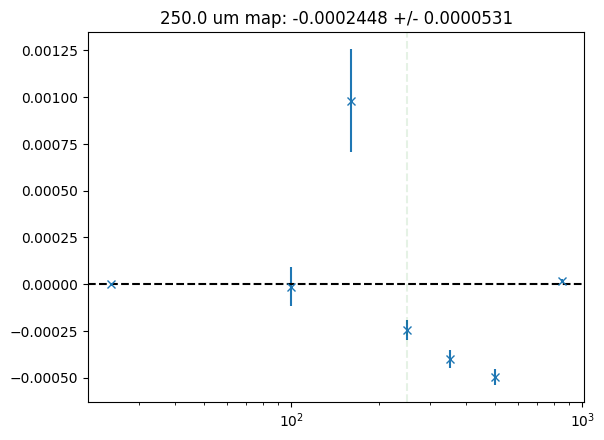

z=0.5_1.0__logM=10.0_10.5__SF?=1 5073 0.832
use informative prior: False
theta0: -35.809335000000004 15.066861135371182 27.602489600000002 None


100%|██████████| 1500/1500 [00:07<00:00, 188.93it/s]


best: -35.102924220197764 16.94632099611705 31.04566006488643


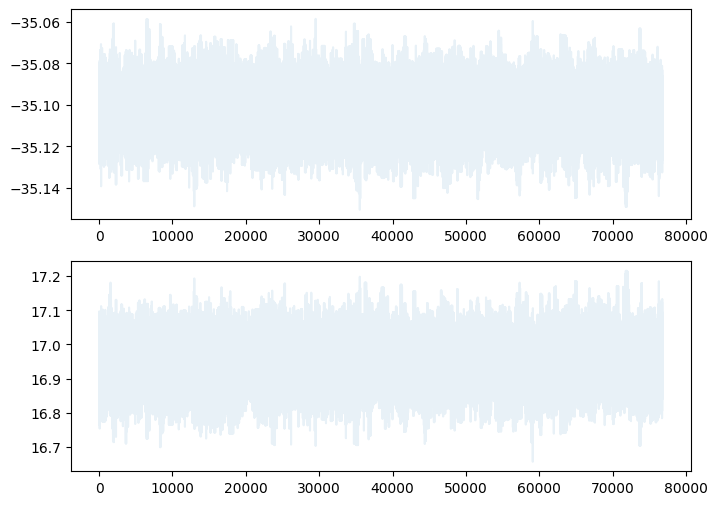

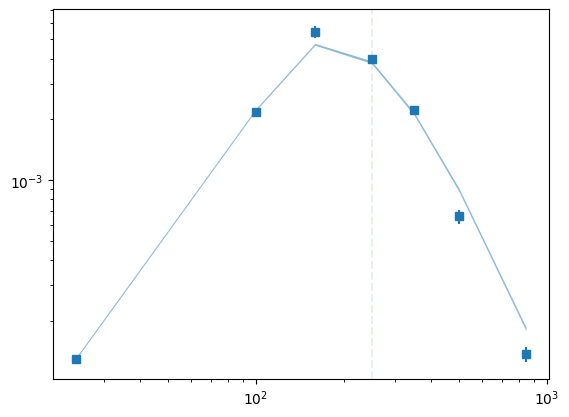

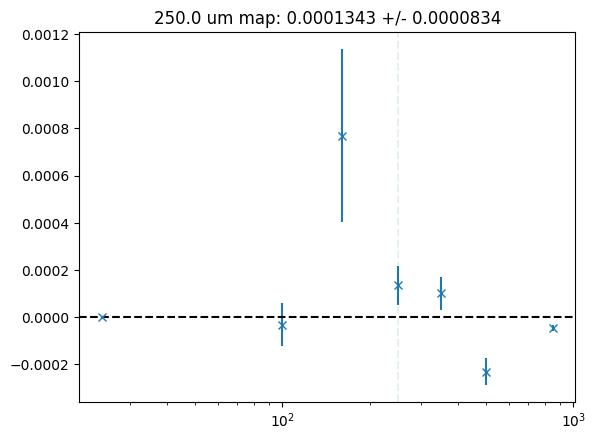

z=0.5_1.0__logM=10.5_11.0__SF?=1 2737 0.8343
use informative prior: False
theta0: -35.27182500000001 15.05607730251322 27.617362596 None


100%|██████████| 1500/1500 [00:07<00:00, 193.23it/s]


best: -34.73993369784665 16.086050351384205 29.50664215954405


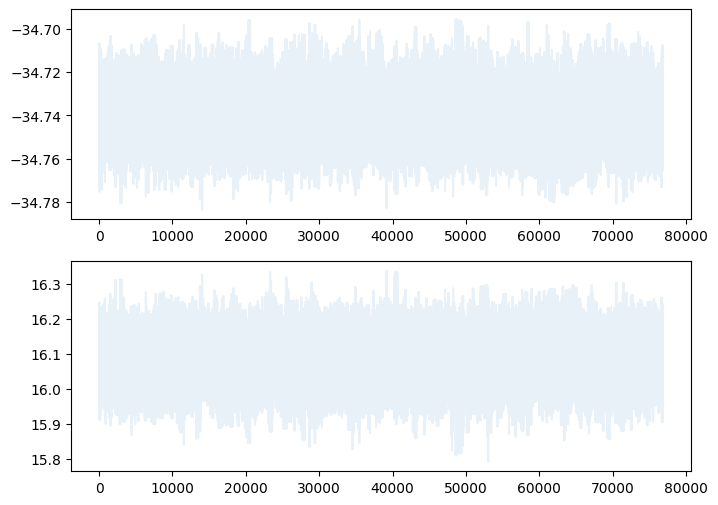

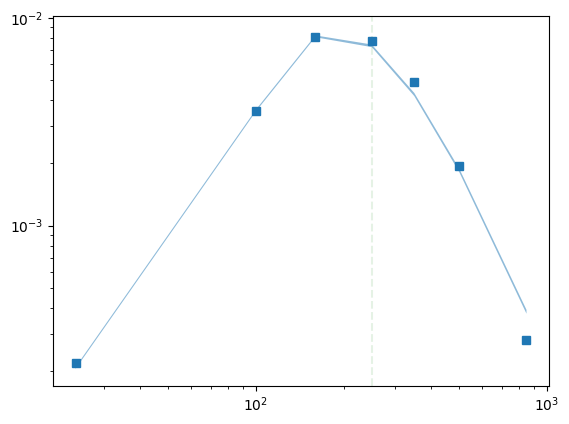

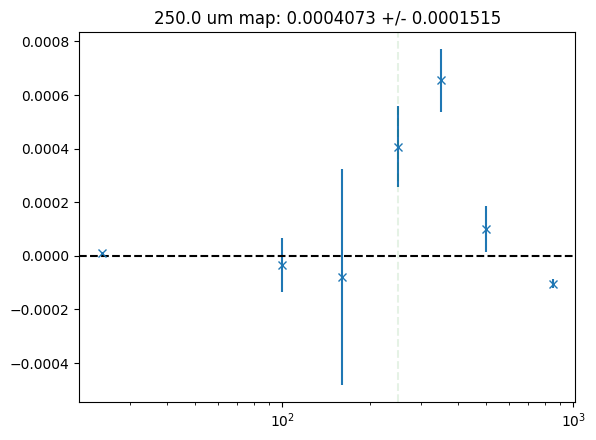

z=0.5_1.0__logM=11.0_12.0__SF?=1 538 0.84625
use informative prior: False
theta0: -34.7937245 15.000517603249829 27.694705624999997 None


100%|██████████| 1500/1500 [00:07<00:00, 190.12it/s]


best: -34.44409647401725 14.760068673323797 27.25077678812406


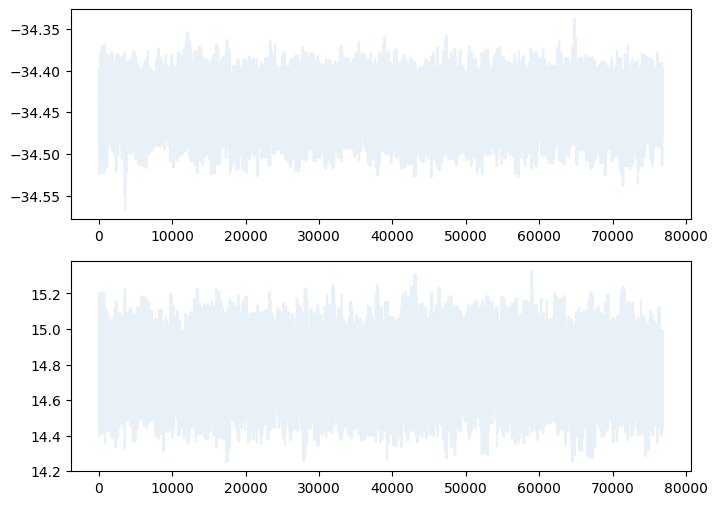

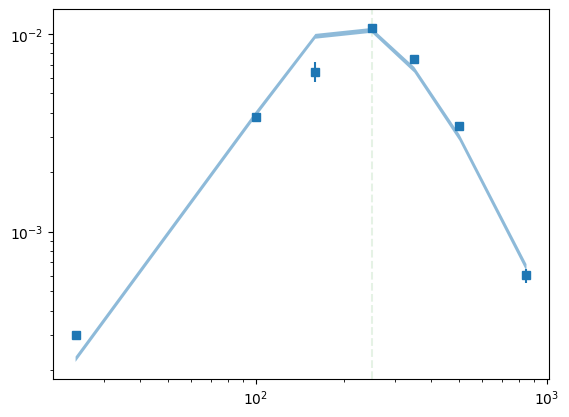

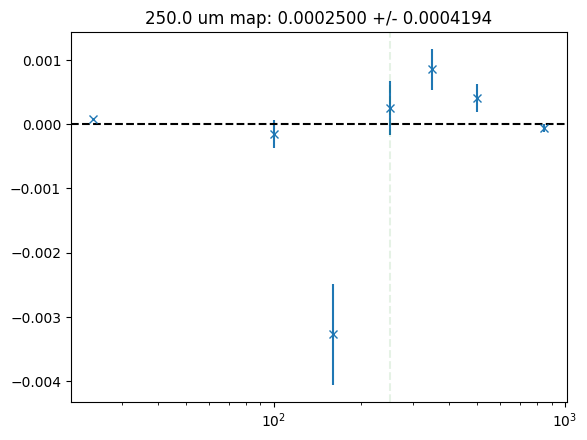

{'z=0.5_1.0__logM=9.5_10.0__SF?=1': (-35.703638345137385,
  17.686874619093732,
  array([4.27386080e-05, 7.41989722e-04, 1.47165896e-03, 1.11373591e-03,
         5.98063775e-04, 2.43411461e-04, 4.85895772e-05]),
  array([7.40642171e-07, 1.28583710e-05, 2.94344582e-05, 3.25315515e-05,
         2.06038862e-05, 9.29842994e-06, 2.01566441e-06]),
  array([[-35.68518413,  17.58853202],
         [-35.73943922,  17.91023846],
         [-35.71406622,  17.78275304],
         ...,
         [-35.76073307,  17.95213011],
         [-35.74143689,  17.92495205],
         [-35.6995468 ,  17.6617298 ]]),
  array([-1.07615329e-06, -1.28451687e-05,  9.81332884e-04, -2.44789112e-04,
         -4.00113005e-04, -4.95272283e-04,  1.85476706e-05]),
  array([1.06176122e-06, 1.02277597e-04, 2.76088751e-04, 5.30801313e-05,
         4.83311660e-05, 4.31549152e-05, 9.37720863e-06])),
 'z=0.5_1.0__logM=10.0_10.5__SF?=1': (-35.102924220197764,
  16.94632099611705,
  array([0.00012741, 0.00221206, 0.00469343, 0.0038320

In [247]:
# loop over emcee code above for keys with "z=1.0_1.5"

emcee_results = {}

for bkey in bkeys:
    if zbin_used not in bkey:
        continue
    if "__SF?=1" not in bkey:
        continue
    print(bkey, results['ngals'][bkey], results['z_med'][bkey])

    x = np.array(results['wvs'])
    y = np.array(results['seds'][bkey])
    yerr = np.array(results['cov'][bkey])
    nd = np.array(results['nd'][bkey])
    z_median = results['z_med'][bkey]
    m_median = results['m_med'][bkey]
    
    use_informative_prior = bkey in informative_prior
    print("use informative prior:", use_informative_prior)
    
    Tmodel = (22.5 + 5.8 * z_median + 0.4 * z_median ** 2) / (1 + z_median)
    Amodel = -47 - z_median*0.05 + 11 * (m_median / 10)
    sigma_T = 0.25 if use_informative_prior else None
    print("theta0:", Amodel, Tmodel, Tmodel * (1 + z_median), sigma_T)
    
    pertubation = 1e-1
    theta0 = (Amodel, Tmodel) if not use_informative_prior else (Amodel, Tmodel, sigma_T)
    ndim, nwalkers = 2, 64
    initial = theta0[:2] + pertubation * np.random.randn(nwalkers, ndim)
    
    args = (x, y, yerr, nd) if not use_informative_prior else (x, y, yerr, nd, theta0)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=args)
    nsteps, burn_in = 1500, 300
    sampler.run_mcmc(initial, nsteps, progress=True)
    
    samples = sampler.get_chain(discard=burn_in, flat=True)
    As, Ts = samples[:, 0], samples[:, 1]
    Abest, Tbest = np.median(As), np.median(Ts)
    print("best:", Abest, Tbest, Tbest * (1 + z_median))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
    ax1.plot(samples[:, 0], alpha=0.1)
    ax2.plot(samples[:, 1], alpha=0.1)
    plt.show()
    plt.close()
    
    C_best = graybody_fn((Abest, Tbest), x)[0]
    C_samples = np.array([graybody_fn((A, T), x)[0] for A, T in samples])
    C_std = np.std(C_samples, axis=0)
    
    plt.figure()
    plt.fill_between(x, C_best - C_std, C_best + C_std, alpha=0.5)
    plt.errorbar(x[~nd], y[~nd], yerr=np.sqrt(np.diag(yerr))[~nd], fmt='s')
    plt.scatter(x[nd], np.sqrt(np.diag(yerr))[nd] * 3.0, c='r', marker='o')
    plt.axvline(x[special_wv_index], color='g', ls='--', alpha=0.1)
    plt.loglog()
    plt.show()
    plt.close()
    
    residuals = y - C_best
    sig_residuals = np.sqrt(np.diag(yerr) + C_std ** 2)
    
    plt.figure()
    plt.title(f"{wvs[special_wv_index]} um map: {residuals[special_wv_index]:.7f} +/- {sig_residuals[special_wv_index]:.7f}")
    plt.errorbar(x, residuals, yerr=sig_residuals, fmt='x')
    plt.axhline(0, color='k', ls='--')
    plt.axvline(x[special_wv_index], color='g', ls='--', alpha=0.1)
    plt.xscale('log')
    plt.show()
    plt.close()
    
    emcee_results[bkey] = (Abest, Tbest, C_best, C_std, samples, residuals, sig_residuals)
    
emcee_results

In [250]:
# add measurements from all bins
res = np.array([emcee_results[bkey][5][special_wv_index] for bkey in emcee_results.keys()])
sig_res = np.array([emcee_results[bkey][6][special_wv_index] for bkey in emcee_results.keys()])

# weighted by the inverse variance
weights = 1 / sig_res ** 2
total_res = np.sum(res * weights) / np.sum(weights)
total_sig_res = 1 / np.sqrt(np.sum(weights))
total_res, total_sig_res, total_res / total_sig_res

(-8.837349621496456e-05, 4.272274809276259e-05, -2.0685349178166605)

note that above is a naive addition, probably want to weigh this by n_gal

In [251]:
total_sig_res / results['beams'][special_wv_index] * 3.0 # 3 sigma limit in Jy/sr

12894.189565220098